In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from os import path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import datetime
import socket
import random
import easydict
from pytz import timezone
import operator
import pandas as pd

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from IPython.display import Image

import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline


In [ ]:
tz = timezone('US/Eastern')

path = "/content/drive/MyDrive/d3_data/" # data directory

# train data
train_wo_file = "train_without_missing.txt"
train_w_file = "train_with_missing.txt"
train_meta = "train.meta"

# validation data
validation_wo_file = "validation_without_missing.txt"
validation_w_file = "validation_with_missing.txt"
validation_meta = "validation.meta"

# test data
test_wo_file = "test_without_missing.txt"
test_w_file = "test_with_missing.txt"
test_meta = "test.meta"

# checkpoint_epoch = 10
checkpoint = None

args = easydict.EasyDict({
    "log_name": "imputation_model",
    "model_type": "mlp",
    "nb_epochs":500,
    "bottleneck_dim":1024,
    "encoder_dim":6,
    "dencoder_dim":6,
    "encoder_dim":0,
    "dencoder_dim":0,
    "batch_size":64,
    "seq_len":137,
    "learning_rate":0.0001,
    "betal":0.5,
    "seed":1,
    "missing_char":".",
    "resnet_mix":0.5,
    "optimizer":"adam",
    "haplotype_cutoff":1.0,
    "filter_size":7,
    "with_region_metadata":True,
    "continent": False,
    "save_model": True,
    "vocab": "dna",
    "log_dir": "log/",
    "annotate": False,
    "latent_dim":64,
    "gan_loss":"vanilla",
    "adapt_lr_iters": 100,
    "gen_dim": 16,
    "disc_dim": 16,
    "gen_layers":1,
    "disc_layers": 1,
    "beta1": 0.5,
    "lmbda": 10,
    "save_embedded_haplotypes": True,
    "vocab_order": None,
    "train_iters": 8000,
    "disc_iters":1,
    "checkpoint_iters": 250,
    "vocab_size": 5,
    "train": True
})

os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = args.seed
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

charmap = {"A":0, "C":1, "G":2, "T":3, args.missing_char:4}
charmap_rev = {0:"A", 1:"C", 2:"G", 3:"T"}

dna_vocab = {"A":0,
             "C":1,
             "G":2,
             "T":3,
             ".":4}

vocab_size = len(charmap)





Collect metadata info

In [ ]:
df_train = pd.read_csv(path + train_meta, sep = '\t',header=None)
df_validation = pd.read_csv(path +validation_meta, sep='\t', header=None)
df_test = pd.read_csv(path+ test_meta, sep='\t', header=None)

In [ ]:
df_train=df_train.fillna("NaN")
df_validation=df_validation.fillna("NaN")
df_test=df_test.fillna("NaN")

In [ ]:
df_validation.head()

,0,1,2
0,SRR11578295,Oceania,Australia
1,SRR12188714,North America,USA
2,ERR4238223,Europe,United Kingdom
3,ERR4305391,Europe,United Kingdom
4,ERR4306402,Europe,United Kingdom


In [ ]:
df_train[1].value_counts()

Europe           4798
Oceania           915
North America     898
Name: 1, dtype: int64

In [ ]:
df_validation[1].value_counts()

Europe           1592
Oceania           319
North America     293
Name: 1, dtype: int64

In [ ]:
df_test[1].value_counts()

Europe           1631
Oceania           287
North America     286
Name: 1, dtype: int64

In [ ]:
countries = {region:i for i, region in enumerate(sorted(set(df_train[1])|set(df_validation[1])|set(df_test[1])))}
countries['NaN'] = len(countries) 
print(countries)

{'Europe': 0, 'North America': 1, 'Oceania': 2, 'NaN': 3}


In [ ]:
if args.continent:
    meta_region = continents
else:
    meta_region = countries

In [ ]:
def charmap_to_onehots(chars, charmap, model_type="resnet2d"):
    onehots = np.int_(np.zeros([len(chars),len(charmap)]))
    I = np.eye(len(charmap))
    for i, char in enumerate(chars):
        onehots[i] = I[charmap[char]]
        
    if model_type == "mlp":
        onehots = np.reshape(onehots, [-1])
    if model_type == "resnet1d" or model_type == "resnet2d":
        onehots = onehots.T
    return onehots

def metadata_to_one_hot(data, nb_classes, model_type = "resnet2d"):
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets].astype(int)[0]

def listToDict(lst):
    op = {lst[i].strip(): lst[i+1].strip() for i in range(0,len(lst), 2)}
    return op
        
def get_vocab(vocab_name, vocab_order=None):
    if vocab_name=="dna":
        charmap = dna_vocab
    elif vocab_name=="rna":
        charmap = rna_vocab
    elif vocab_name=="dna_nt_only":
        charmap = dna_nt_only_vocab
    elif vocab_name=="rna_nt_only":
        charmap = rna_nt_only_vocab
    else:
        raise Exception("Unknown vocabulary name.")

    if vocab_order:
        if set(vocab_order) != set(charmap):
            raise ValueError("Provided `vocab` and `vocab_order` arguments are not compatible")
        else:
            charmap = {c: idx for idx, c in enumerate(vocab_order)}

    rev_charmap = {v: k for k, v in charmap.items()}
    return charmap, rev_charmap

# for GANs

def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

def z_sampler(batch_size, latent_dim):
    """Function to provide noise that will be fed to the generator"""
    return Variable(torch.randn(batch_size, latent_dim)).to(device)


def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)
    )

def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

def ones_or_zeros_like(tensor, disc_exp):
    if disc_exp=="real":
        return Variable(torch.FloatTensor(tensor.size()).fill_(1.), requires_grad=False).to(device)
    elif disc_exp=="fake":
        return Variable(torch.FloatTensor(tensor.size()).fill_(0.), requires_grad=False).to(device)

def log(args, samples_dir=False):
    """Create logging directory structure according to args."""
    if hasattr(args, "checkpoint") and args.checkpoint:
        return _log_from_checkpoint(args)
    else:
        stamp = datetime.date.strftime(datetime.datetime.now(), "%Y.%m.%d-%Hh%Mm%Ss") + "_{}".format(socket.gethostname())
        full_logdir = os.path.join(args.log_dir, args.log_name, stamp)
        os.makedirs(full_logdir, exist_ok=True)
        if samples_dir: os.makedirs(os.path.join(full_logdir, "samples"), exist_ok=True)
        args.log_dir = "{}:{}".format(socket.gethostname(), full_logdir)
        _log_args(full_logdir, args)
    return full_logdir, 0

def _log_from_checkpoint(args):
    """Infer logging directory from checkpoint file."""
    int_dir, checkpoint_name = os.path.split(args.checkpoint)
    logdir = os.path.dirname(int_dir)
    checkpoint_num = int(checkpoint_name.split('_')[1])
    _log_args(logdir, args, modified_iter=checkpoint_num)
    return logdir, checkpoint_num

def _log_args(logdir, args, modified_iter=0):
    """Write log of current arguments to text."""
    keys = sorted(arg for arg in dir(args) if not arg.startswith("_"))
    args_dict = {key: getattr(args, key) for key in keys}
    with open(os.path.join(logdir, "config.txt"), "a") as f:
        f.write("Values at iteration {}\n".format(modified_iter))
        for k in keys:
            s = ": ".join([k,str(args_dict[k])]) + "\n"
            f.write(s)
        vocab_order = args.vocab_order if hasattr(args, "vocab_order") else None
        charmap, _ = get_vocab(args.vocab, vocab_order)
        charmap_strs = []
        for k,v in charmap.items():
            charmap_strs.append("'{}':{}".format(k,v))
        f.write("charmap: " + ", ".join(charmap_strs))
        f.write("\n")

def log_training_results(logdir, train_iters, true_count, train_scores_mean, valid_scores_mean, 
                         current_iteration_elapsed, online_print=True):
    """Write log of the results to text."""

    res_to_have = ("Iteration {}/{}: train_diff={:.5f}, valid_diff={:.5f} ({}sec)".format(
              train_iters, true_count, train_scores_mean, valid_scores_mean, current_iteration_elapsed))
    
    if online_print: 
        print(res_to_have)

    with open(os.path.join(logdir, "results.txt"), "a") as f: 
        f.write("{}\n".format(res_to_have))

def save_samples(logdir, samples, iteration, rev_charmap, annotated=False):
    """Convert samples to strings and save to log directory."""
    if annotated:
        char_probs = samples[:,:-1,:]
        ann = samples[:,-1,:]
    else:
        char_probs = samples
    argmax = np.argmax(char_probs, 1)
    with open(os.path.join(logdir, "samples", "samples_{}".format(iteration)), "w") as f:
        for line in argmax:
            s = "".join(rev_charmap[d] for d in line) + "\n"
            f.write(s)
    if annotated:
        np.savetxt(os.path.join(logdir, "samples", "samples_ann_{}".format(iteration)), ann)

def plot(y, x, logdir, name, xlabel=None, ylabel=None, title=None, save=True):
    """Make plot of training curves"""
    plt.close()
    plt.plot(y,x)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title = title
    if save:
        plt.savefig(os.path.join(logdir, "{}".format(name) + ".png"))
        plt.close()

def feed(data, batch_size, reuse=True):
    """Feed data in batches"""
    if type(data)==list or type(data)==tuple and len(data)==2:
        data_seqs, data_vals = data
        yield_vals = True
    else:
        data_seqs = data
        yield_vals = False
    num_batches = len(data_seqs) // batch_size
    if num_batches == 0:
        raise Exception("Dataset not large enough to accomodate batch size")
    while True:
        for ctr in range(num_batches):
            out = data_seqs[ctr * batch_size : (ctr + 1) * batch_size]
            if yield_vals:
                out = (out, data_vals[ctr * batch_size : (ctr + 1) * batch_size])
            yield out
        if not reuse and ctr == num_batches - 1:
            yield None

def save_models(logdir, generator, discriminator, true_count):
    """Function to save Denerator and Discriminator models (checkpointing)"""
    ckpt_dir = os.path.join(logdir, "checkpoints", "checkpoint_{}".format(true_count))
    os.makedirs(ckpt_dir, exist_ok=True)
    torch.save(generator.state_dict(), '{}/netG'.format(ckpt_dir))
    torch.save(discriminator.state_dict(), '{}/netD'.format(ckpt_dir))
    
def cal_time(former_iteration_endpoint ,tz):
    """Calculating 'Computation Time' for this round of iteration"""
    current_iteration_endpoint = datetime.datetime.now(tz)
    current_iteration_elapsed = str(current_iteration_endpoint - former_iteration_endpoint).split(".")[0]
    temp = current_iteration_elapsed.split(":")
    if int(temp[0])==0 and int(temp[1])==0: current_iteration_elapsed = temp[2]
    elif int(temp[0])==0: current_iteration_elapsed = temp[1]+":"+temp[2]
    former_iteration_endpoint = current_iteration_endpoint
    return former_iteration_endpoint, current_iteration_elapsed

def save_samples(logdir, samples, iteration, rev_charmap, annotated=False):
    """Convert samples to strings and save to log directory."""
    if annotated:
        char_probs = samples[:,:-1,:]
        ann = samples[:,-1,:]
    else:
        char_probs = samples
    argmax = np.argmax(char_probs, 1)
    with open(os.path.join(logdir, "samples", "samples_{}".format(iteration)), "w") as f:
        for line in argmax:
            s = "".join(rev_charmap[d] for d in line) + "\n"
            f.write(s)
    if annotated:
        np.savetxt(os.path.join(logdir, "samples", "samples_ann_{}".format(iteration)), ann)



## Initiate the Dataset Class:

In [ ]:
class CovidDataset(Dataset):
    def __init__(self, path, files, model, split="train", 
                 charmap=charmap, haplotype_cutoff=args.haplotype_cutoff, 
                 meta_continent=args.continent, meta_region=meta_region):
        """
        Args:
            :param path: path to dataset file
            :param file: dataset file name
            :param model: model of interest to work with
            :charmap: dict that maps nucleotides into digits which represet indexes of vectors in one-hot matrix
            ...
        """        
        self.dataset = {}
        for file in files[0]:
            with open(os.path.join(path, file), 'r') as f:
                content = f.readlines()
                templist = []
                for line in content:
                    seq_id, seq = line.strip().split("\t",1)
                    templist.append(seq_id)
                    templist.append(seq.replace("\t", ""))
                self.dataset = {**self.dataset, **listToDict(templist)}
                print("number of samples with duplication:", len(list(self.dataset.values())))
                print("number of samples without duplication:", len(set(list(self.dataset.values()))))
                #self.dataset = {**self.dataset, **listToDict(content)}
        self.dataset_new = {}
        for k, v in self.dataset.items(): # not including seq. with many miss. val. (based on haplotype_cutoff)
            if '.' in v:
                if v.count('.')/len(v) <= args.haplotype_cutoff: 
                    self.dataset_new[k] = v
            else:
                self.dataset_new[k] = v
        self.dataset = self.dataset_new
        #print(self.dataset)
        
        self.sequences = [charmap_to_onehots(sequence, charmap, model) for sequence in list(self.dataset.values())]
        self.ids = list(range(len(list(self.dataset))))
        
        index = 0
        if args.continent: index = 2 # for continent
        else: index = 1 # for country
           
#        meta_place = {}        
#        for file in files[1]:
#            df = pd.read_csv(path + file, sep='\t', lineterminator='\n', header=None)
#            df = df.fillna("NaN")
#            meta_temp = {name:place for name, place in zip(list(df[0]), list(df[index]))}
#            meta_place = {**meta_place, **meta_temp}
            
#        self.meta_place = {}
#        for i, name in enumerate(self.dataset):
#            self.meta_place[i] = metadata_to_one_hot(meta_region[meta_place[name]], len(meta_region)+1)
          
    def __getitem__(self, i):
        id = self.ids[i]
        return self.sequences[id]#, self.meta_place[id]
    
    def __len__(self):
        return len(self.ids)

In [ ]:
dataset_train = CovidDataset(path, [[train_w_file], [train_meta]], args.model_type)
dataset_validation = CovidDataset(path, [[validation_w_file], [validation_meta]], args.model_type)
dataset_test = CovidDataset(path, [[test_w_file], [test_meta]], args.model_type)

number of samples with duplication: 6611
number of samples without duplication: 1779
number of samples with duplication: 2204
number of samples without duplication: 697
number of samples with duplication: 2204
number of samples without duplication: 710


In [ ]:
dataloader_train = DataLoader(dataset_train, args.batch_size, drop_last = True, shuffle = True)
dataloader_validation = DataLoader(dataset_validation, args.batch_size,drop_last=False,shuffle= False)
dataloader_test = DataLoader(dataset_test, args.batch_size,drop_last=False,shuffle= False)

In [ ]:
dataset_train_gan = CovidDataset(path, [[train_w_file]], args.model_type)
dataset_validation_gan = CovidDataset(path, [[validation_w_file]], args.model_type)
dataset_test_gan = CovidDataset(path, [[test_w_file]], args.model_type)

number of samples with duplication: 6611
number of samples without duplication: 1779
number of samples with duplication: 2204
number of samples without duplication: 697
number of samples with duplication: 2204
number of samples without duplication: 710


In [ ]:
dataloader_train_gan = DataLoader(dataset_train_gan, args.batch_size, drop_last = True, shuffle = True)
dataloader_validation_gan = DataLoader(dataset_validation_gan, args.batch_size,drop_last=False,shuffle= False)
dataloader_test_gan = DataLoader(dataset_test_gan, args.batch_size,drop_last=False,shuffle= False)

In [ ]:
# fix vocab

charmap, rev_charmap = get_vocab(args.vocab, args.vocab_order)

In [ ]:
# organize model logs/checkpoints
logdir, checkpoint_baseline = log(args, samples_dir=True)
    
if args.annotate:
    data_enc_dim = vocab_size + 1
else:
    data_enc_dim = vocab_size
data_size = args.seq_len * data_enc_dim

In [ ]:
len(dataloader_train)
# dataloader -> model -> criterion -> optimizer -> training loop

103

In [ ]:
len(dataloader_validation)

35

In [ ]:
examples = iter(dataloader_train)
samples, labels = examples.next()
print(samples.shape, labels.shape)

ValueError: ignored

Early stopping

In [ ]:
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)


# Model: Multi-Layer Perceptron

In [ ]:
class mlp_generator(nn.Module):
    """ Multi-Layer Perceptron for generating sequences.

    Parameters:
        inputs (tensor):Batch of noises inputed to the network.
        dim (int):Generator dimension parameter (in each middle layer).
        input_size (int):Size of latent space (i.e., the first layer dimension).
        output_size (int):Size of the last layer (=max_seq_len*vocab_size).
        num_layers (int):How many middle or hidden layers for generator.

    Returns:
        outputs (tensor):Batch of lists of values (each `vocab_size` interval represents one nucleotide).   

    """
    def __init__(self, dim=64, input_size=685, output_size=3, num_layers=4): # 5 x 137
        super(mlp_generator, self).__init__()

        num_layers = num_layers + 2  # add 2 for the 1st and the last layers
        modules = []
        for layer in range(num_layers): 
            in_size = input_size if layer == 0 else dim
            out_size = output_size if layer == num_layers - 1 else dim
            if layer < num_layers - 1:
                modules.append(
                    nn.Sequential(
                        nn.Linear(in_size, out_size),
                        nn.ReLU(True),
                    )
                )
            else:
                modules.append(
                    nn.Sequential(
                        nn.Linear(in_size, out_size),
                        nn.Sigmoid()
                    )
                )
        self.layers = nn.Sequential(*modules)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

# rename to mlp_classifier
# outsize of disc = 17 (for countries)
class mlp_discriminator(nn.Module):
    """ Multi-Layer Perceptron for discriminating real vs generated sequences.

    Parameters:
        inputs (tensor):Tensor of size (batch_size, vocab_size*max_seq_len) containing real or generated sequences.
        dim (int):Discriminator dimension parameter (in each middle layer).
        input_size (int):Size of the first layer (vocab_size*max_seq_len).
        num_layers (int):How many middle or hidden layers for discriminator.

    Returns:
        outputs (tensor):Batch of (single) values for real or generated inputs.   

    """
    def __init__(self, dim, input_size, num_layers=4):
        super(mlp_discriminator, self).__init__()
        
        num_layers = num_layers + 2  # add 2 for the 1st and the last layers
        modules = []
        for layer in range(num_layers):
            in_size = input_size if layer == 0 else dim
            out_size = 4 if layer == num_layers - 1 else dim # if not last layer then uses dim size
            if layer < num_layers - 1:
                modules.append(
                    nn.Sequential(
                        nn.Linear(in_size, out_size),
                        nn.LeakyReLU(True),
                    )
                )
            else:
                modules.append(
                    nn.Sequential(
                        nn.Linear(in_size, out_size),
                    )
                )
        self.layers = nn.Sequential(*modules)
        
    def forward(self, inputs):
        inputs = inputs.view(inputs.size(0), -1)
        outputs = self.layers(inputs)
        return outputs

# Criterion + Optimizer:

In [ ]:
vocab_size = 5# instantiate models
if args.model_type=="mlp":
    netG = mlp_generator(args.gen_dim, args.latent_dim, args.seq_len*args.vocab_size, args.gen_layers).to(device)
    netD = mlp_discriminator(args.disc_dim, args.seq_len*vocab_size, args.disc_layers).to(device) #fix max_seq_len
   # model = mlp_classifier(args.disc_dim, args.seq_len*vocab_size, args.disc_layers).to(device)
print("{}\nGenerator Network Architecture:\n{}\n{}\n".format("="*31, "~"*31, netG))
print("{}\nDiscriminator Network Architecture:\n{}\n{}\n".format("="*35, "~"*35, netD))

# cost function (for discriminator prediction)
# criterion = nn.BCEWithLogitsLoss() # use CE loss for classifier
criterion = nn.BCEWithLogitsLoss()

# setup optimizer
optimizerG = optim.Adam(list(netG.parameters()), lr=args.learning_rate)
optimizerD = optim.Adam(list(netD.parameters()), lr=args.learning_rate)
# optimizerM = optim.Adam(list(model.parameters()), lr=args.learning_rate, betas=(args.beta1, 0.999))

schedulerG = optim.lr_scheduler.ExponentialLR(optimizerG, gamma=0.99)
schedulerD= optim.lr_scheduler.ExponentialLR(optimizerD, gamma=0.99)

Generator Network Architecture:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
mlp_generator(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=16, bias=True)
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=16, out_features=685, bias=True)
      (1): Sigmoid()
    )
  )
)

Discriminator Network Architecture:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
mlp_discriminator(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=685, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=True)
    )
    (1): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=True)
    )
    (2): Sequential(
      (0): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)



In [ ]:
def disc_grad_penalty(disc, real_samples, penalty_amount=10, retain=False):
    """Function to compute gradient (norm) penalty loss in order to hinder undesirable large changes in gradient computation 

    Parameters:
        disc_network (torch.nn.module):Discriminator object.
        real_samples (tensor):'Real' data samples.
        penalty_amount (in):'lmbda' or weight of the penalty.
        retain (bool):If False, the graph used to compute the grad will be freed (i.e., cannot do another loss.backward)
        
    Returns:
        GP_loss (int):Gradient (norm) penalty loss (ie. of the gradient regularization term in the total loss funtion).

    """
    def _get_gradient(inp, output):
        gradient = torch.autograd.grad(outputs=output, inputs=inp,
                                 grad_outputs=torch.ones_like(output),
                                 create_graph=True, retain_graph=True,
                                 only_inputs=True, allow_unused=True)[0]
        return gradient
    
    if not isinstance(real_samples, (list, tuple)):
        real_samples = [real_samples]
        
    real_samples = [inp.detach() for inp in real_samples]
    real_samples = [inp.requires_grad_() for inp in real_samples]
    with torch.set_grad_enabled(True):
        output = disc(*real_samples)
    
    # compute gradient
    gradient = _get_gradient(real_samples, output)
    
    # get norm square: ||grad||^2
    gradient = gradient.view(gradient.size()[0], -1)
    penalty = (gradient ** 2).sum(1).mean()
    
    gp_loss = penalty_amount * penalty
    
    gp_loss.backward(retain_graph=retain)
    
    return gp_loss

def backprop(disc_network, inputs, disc_exp=None, retain=False, backward=True, criterion=criterion):
    outputs = disc_network(inputs)
    y = ones_or_zeros_like(outputs, disc_exp)
    # In D update: 
    # for 'real' (y=1) will compute: ylog(outputs)+0*log(1-outputs) using BCEWithLogitsLoss
    # for 'fake' (y=0) will compute: 0*log(outputs)+(1-y)*log(1-outputs) using BCEWithLogitsLoss
    # In G update:
    # for 'fake' (y=1) will compute: y*log(outputs)+0*log(1-outputs) using BCEWithLogitsLoss
    loss = criterion(outputs, y)
    if backward:
        loss.backward(retain_graph=retain)  # accumulating gradients (ie. dloss/dw)  (compute/store gradients, but don't change params)
    return loss, outputs

# Training Loop + Metrics:

In [ ]:
# train GAN
start_time = datetime.datetime.now(tz)
former_iteration_endpoint = start_time
print("~~ TIME ~~")
print("Time started: {}".format(start_time.strftime("%Y-%m-%d %H:%M:%S")))
print("======================================================================")
print("Training GAN (using '{}' loss algorithm with '{}' model)".format(args.gan_loss, args.model_type))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
train_counts = []
valid_counts = []
disc_loss_train = []
disc_loss_valid = []
gen_loss_train = []
train_scores = []
for idx in range(args.train_iters):
    true_count = idx + 1 + checkpoint_baseline
    train_counts.append(true_count)
    
    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))) + GP(disc_grad_penalty) wanting D(x)=1 & D(G(z))=0
    ############################
    optimizerG.zero_grad()
    optimizerD.zero_grad()
    
    lossD_iters = 0
    for d in range(args.disc_iters):
        # 'Real' data
        real_seqs = next(iter(dataloader_train_gan)) # next(iter dataloader train...)
        real_seqs = Variable(real_seqs.clone().detach().float().to(device))
        lossD_real, score_real = backprop(netD, real_seqs, disc_exp="real")
        
        # 'Fake' data
        noise = z_sampler(args.batch_size, args.latent_dim)
        fake_seqs = netG(noise)
  
        
        # gradient penalty loss
        lossD_GP = disc_grad_penalty(netD, real_seqs, penalty_amount=args.lmbda)
        
        # Total loss
        lossD_fake, score_fake = backprop(netD.eval(), fake_seqs, disc_exp="fake", backward=False)
        train_score = score_real.data.mean().item() - score_fake.data.mean().item()
        train_scores.append(train_score)
        lossD = lossD_real.item() + lossD_fake.item() + lossD_GP.item()
        
        optimizerD.step()
        
    disc_loss_train.append((lossD_real + lossD_fake)/2)
        
    ############################
    # (2) Update G network: maximize log(D(G(z))) wanting D(G(z))=1
    ############################
    optimizerG.zero_grad()
    optimizerD.zero_grad()
    
    noise = z_sampler(args.batch_size, args.latent_dim)
    fake_seqs = netG(noise)
    lossG, _ = backprop(netD, fake_seqs, disc_exp="real")
    gen_loss_train.append(lossG.item())

    optimizerG.step()
    
    if true_count % args.adapt_lr_iters == 0:
        schedulerG.step()
        schedulerD.step()
    
    if true_count % args.checkpoint_iters == 0:
        # validation
        loss_vals = []
        valid_scores = []
#        data = next(iter(dataloader_validation_gan))
        for data in dataloader_validation_gan:
            # How discriminator works on the real samples?
            real_seqs = Variable(data.clone().detach().float().to(device))
            lossD_real, score_real = backprop(netD.eval(), real_seqs, disc_exp="real", backward=False)
        
            # How discriminator works on the fake samples?
            noise = z_sampler(args.batch_size, args.latent_dim)
            fake_seqs = netG.eval()(noise)
            lossD_fake, score_fake = backprop(netD.eval(), fake_seqs, disc_exp="fake", backward=False)
        
            # How close the guesses are?
            valid_score = score_real.data.mean().item() - score_fake.data.mean().item()
            valid_scores.append(valid_score)
            loss_vals.append(lossD_real.item() + lossD_fake.item())
#            data = next(iter(dataloader_validation_gan))

        disc_loss_valid.append(np.mean(loss_vals))
        valid_counts.append(true_count)
        
        # log results and figures
        name = "valid_disc_cost"
        if checkpoint_baseline > 0: name += "_{}".format(checkpoint_baseline)
        plot(valid_counts, disc_loss_valid, logdir, name, xlabel="Iteration", ylabel="Discriminator cost")
        
        # Calculating 'Computation Time' for this round of iteration
        former_iteration_endpoint, current_iteration_elapsed = cal_time(former_iteration_endpoint, tz)
        
        """print("Iteration {}/{}: train_diff={:.5f}, valid_diff={:.5f} ({}sec)".format(
            true_count, args.train_iters, np.mean(train_scores), np.mean(valid_scores), current_iteration_elapsed))"""
        log_training_results(logdir, true_count, args.train_iters, np.mean(train_scores), np.mean(valid_scores), current_iteration_elapsed)

        fake_seqs = fake_seqs.reshape([-1, data_enc_dim, args.seq_len])
        save_samples(logdir, fake_seqs.cpu().clone().detach().numpy(), true_count, rev_charmap, annotated=args.annotate)
        
        name = "train_disc_cost"
        if checkpoint_baseline > 0: name += "_{}".format(checkpoint_baseline)
        plot(train_counts, disc_loss_train, logdir, name, xlabel="Iteration", ylabel="Min-Max discriminator trun loss")
        
        name = "train_gen_cost"
        if checkpoint_baseline > 0: name += "_{}".format(checkpoint_baseline)
        plot(train_counts, gen_loss_train, logdir, name, xlabel="Iteration", ylabel="Min-Max generator turn loss")
        
        train_scores = []

        print(idx)
        
    # save checkpoint
    if args.checkpoint_iters and true_count % args.checkpoint_iters == 0:
        save_models(logdir, netG, netD, true_count)

print("======================================================================")
current_time = datetime.datetime.now(tz)
time_elapsed = current_time - start_time
print("Time current: {}".format(current_time.strftime("%Y-%m-%d %H:%M:%S")))
print("Time elapsed: {}".format(str(time_elapsed).split(".")[0]))

~~ TIME ~~
Time started: 2021-04-13 15:45:43
Training GAN (using 'vanilla' loss algorithm with 'mlp' model)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Iteration 250/8000: train_diff=0.04813, valid_diff=0.08121 (02sec)
249
Iteration 500/8000: train_diff=0.07746, valid_diff=0.07030 (02sec)
499
Iteration 750/8000: train_diff=0.05743, valid_diff=0.04243 (02sec)
749
Iteration 1000/8000: train_diff=0.02882, valid_diff=0.01681 (02sec)
999
Iteration 1250/8000: train_diff=0.00890, valid_diff=0.00284 (02sec)
1249
Iteration 1500/8000: train_diff=0.00017, valid_diff=-0.00157 (02sec)
1499
Iteration 1750/8000: train_diff=-0.00347, valid_diff=-0.00526 (02sec)
1749
Iteration 2000/8000: train_diff=-0.00473, valid_diff=-0.00528 (02sec)
1999
Iteration 2250/8000: train_diff=-0.00502, valid_diff=-0.00407 (02sec)
2249
Iteration 2500/8000: train_diff=-0.00444, valid_diff=-0.00391 (02sec)
2499
Iteration 2750/8000: train_diff=-0.00367, valid_diff=-0.00409 (02sec)
2749
Iteration 3000

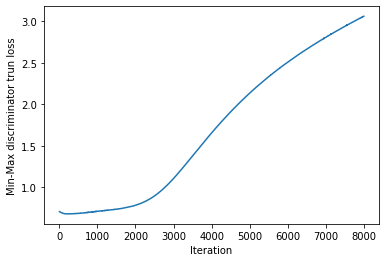

In [ ]:
# Plotting discriminator loss
name = "train_disc_cost"
plot(train_counts, disc_loss_train, logdir, name, xlabel="Iteration", ylabel="Min-Max discriminator trun loss", save=False)

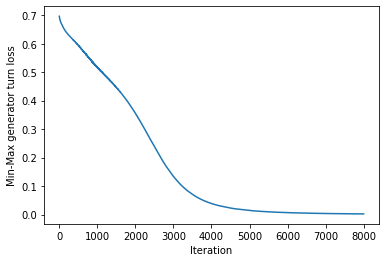

In [ ]:
# Plotting generator turn loss
name = "train_gen_cost"
plot(train_counts, gen_loss_train, logdir, name, xlabel="Iteration", ylabel="Min-Max generator turn loss", save=False)

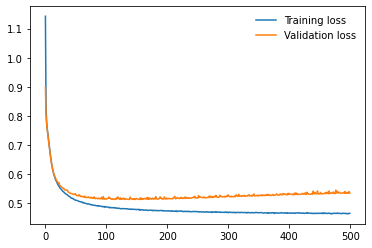

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
predictions = [] # instead of correct
targets = [] # instead of total
for inputs in dataloader_test:
    inputs = inputs.to(device)
    preds = model.eval()(inputs.float())
    predictions.extend(torch.argmax(preds, 1).tolist())
print(classification_report(targets, predictions))

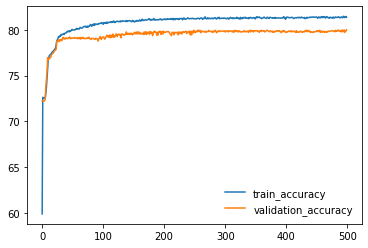

In [ ]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(valid_accuracies, label='validation_accuracy')
plt.legend(frameon=False)
plt.show()

In [ ]:
predictions = [] # instead of correct
targets = [] # instead of total
for inputs, labels in dataloader_test:
    inputs, labels = inputs.to(device), labels.to(device)
    preds = model.eval()(inputs.float())
    predictions.extend(torch.argmax(preds, 1).tolist())
    targets.extend(torch.argmax(labels, 1).tolist())
print(classification_report(targets, predictions, labels=list(set(targets))))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1631
           1       0.73      0.15      0.25       286
           2       0.79      0.57      0.67       287

    accuracy                           0.81      2204
   macro avg       0.78      0.57      0.60      2204
weighted avg       0.80      0.81      0.77      2204



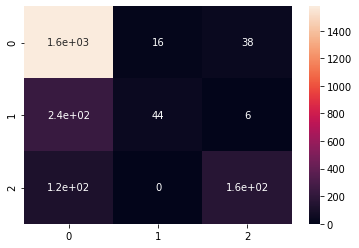

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(targets, predictions))

sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
model_test =torch.load("/content/drive/MyDrive/d3_data/model.pth")
model_test.eval()


mlp_classifier(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=685, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=True)
    )
    (1): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=True)
    )
    (2): Sequential(
      (0): Linear(in_features=16, out_features=17, bias=True)
    )
  )
)

In [ ]:
dataiter = iter(dataloader_test)
sequences, labels = dataiter.next()

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(17)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

## Ignore all below, old code!

In [ ]:
nb_epochs = args.nb_epochs
def train(epoch):
    n = 0
    for epoch in range(nb_epochs):
        for seqs, labels in iter(dataloader_train):
            print("step 1")
            zs = model(seqs.float())
            print("completed  model")
            loss = criterion(zs, labels) # computes total loss
            print("computed loss")
            loss.backward() # compute updates for each parameter
            print("updated")
            optimizer.step() # make the updates for each param.
            optimizer.zero_grad() # clean up step 
            print(epoch)
        
            n += 1 
    
    return model

In [ ]:
test = train(10)

In [ ]:
seqs, labels = next(iter(dataloader_train))

In [ ]:
print(seqs.shape)
print(labels.shape)

## Disregard the code under (old stuff):

In [ ]:
seqs, labels = next(iter(dataloader_train))

In [ ]:
print(labels.shape)

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=685, im_dim=685, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)
    
class Discriminator(nn.Module):
    def __init__(self, im_dim=685, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        return self.disc(image)
    

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=args.learning_rate)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=args.learning_rate)

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
for epoch in range(args.nb_epochs):
  
    # Dataloader returns the batches
    for real in dataloader_train:
        cur_batch_size = len(real)
        print(real.shape)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step
        
        print(epoch)
        
        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

In [ ]:
print(args.nb_epochs)

In [ ]:
class mlp_generator(nn.Module):
    """ Multi-Layer Perceptron for generating sequences.

    Parameters:
        inputs (tensor):Batch of noises inputed to the network.
        dim (int):Generator dimension parameter (in each middle layer).
        input_size (int):Size of latent space (i.e., the first layer dimension).
        output_size (int):Size of the last layer (=max_seq_len*vocab_size).
        num_layers (int):How many middle or hidden layers for generator.

    Returns:
        outputs (tensor):Batch of lists of values (each `vocab_size` interval represents one nucleotide).   

    """
    def __init__(self, dim=200, input_size=100, output_size=10, num_layers=4):
        super(mlp_generator, self).__init__()

        num_layers = num_layers + 2  # add 2 for the 1st and the last layers
        modules = []
        for layer in range(num_layers): 
            in_size = input_size if layer == 0 else dim
            out_size = output_size if layer == num_layers - 1 else dim
            if layer < num_layers - 1:
                modules.append(
                    nn.Sequential(
                        nn.Linear(in_size, out_size),
                        nn.ReLU(True),
                    )
                )
            else:
                modules.append(
                    nn.Sequential(
                        nn.Linear(in_size, out_size),
                        nn.Sigmoid()
                    )
                )
        self.layers = nn.Sequential(*modules)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x


class mlp_discriminator(nn.Module):
    """ Multi-Layer Perceptron for discriminating real vs generated sequences.

    Parameters:
        inputs (tensor):Tensor of size (batch_size, vocab_size*max_seq_len) containing real or generated sequences.
        dim (int):Discriminator dimension parameter (in each middle layer).
        input_size (int):Size of the first layer (vocab_size*max_seq_len).
        num_layers (int):How many middle or hidden layers for discriminator.

    Returns:
        outputs (tensor):Batch of (single) values for real or generated inputs.   

    """
    def __init__(self, dim, input_size, num_layers=4):
        super(mlp_discriminator, self).__init__()
        
        num_layers = num_layers + 2  # add 2 for the 1st and the last layers
        modules = []
        for layer in range(num_layers):
            in_size = input_size if layer == 0 else dim
            out_size = 1 if layer == num_layers - 1 else dim
            if layer < num_layers - 1:
                modules.append(
                    nn.Sequential(
                        nn.Linear(in_size, out_size),
                        nn.LeakyReLU(0.2, inplace=True),
                    )
                )
            else:
                modules.append(
                    nn.Sequential(
                        nn.Linear(in_size, out_size),
                    )
                )
        self.layers = nn.Sequential(*modules)
        
    def forward(self, inputs):
        inputs = inputs.view(inputs.size(0), -1)
        outputs = self.layers(inputs)
        return outputs


In [ ]:
# instantiate models
if args.model_type=="mlp":
    netG = mlp_generator(args.gen_dim, args.latent_dim, args.max_seq_len*vocab_size, args.gen_layers).to(device)
    netD = mlp_discriminator(args.disc_dim, args.max_seq_len*vocab_size, args.disc_layers).to(device)
elif args.model_type=="resnet1d":
    netG = resnet_generator_1d(args.gen_dim, args.latent_dim, vocab_size, args.max_seq_len, args.gen_layers).to(device)
    netD = resnet_discriminator_1d(args.disc_dim, vocab_size, args.max_seq_len, args.disc_layers).to(device)
elif args.model_type=="resnet2d":
    netG = resnet_generator_2d(args.gen_dim, args.latent_dim, vocab_size, args.max_seq_len, args.gen_layers).to(device)
    netD = resnet_discriminator_2d(args.disc_dim, vocab_size, args.max_seq_len, args.disc_layers).to(device)

print("{}\nGenerator Network Architecture:\n{}\n{}\n".format("="*31, "~"*31, netG))
print("{}\nDiscriminator Network Architecture:\n{}\n{}\n".format("="*35, "~"*35, netD))

# cost function (for discriminator prediction)
criterion = nn.BCEWithLogitsLoss()

# setup optimizer
optimizerG = optim.Adam(list(netG.parameters()), lr=args.learning_rate, betas=(args.beta1, 0.999))
optimizerD = optim.Adam(list(netD.parameters()), lr=args.learning_rate, betas=(args.beta1, 0.999))

# use an exponentially decaying learning rate
schedulerG = optim.lr_scheduler.ExponentialLR(optimizerG, gamma=0.99)
schedulerD= optim.lr_scheduler.ExponentialLR(optimizerD, gamma=0.99)